<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/sfere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Monai install

%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

In [2]:
# @title Import

import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai
import glob
from glob import glob
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.utils import set_determinism
import nibabel as nib
from nibabel import load, save, Nifti1Image
import logging
import sys
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
import gc
gc.collect()
torch.cuda.empty_cache()

from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

from monai.data import (
    DataLoader,
    decollate_batch,
    create_test_image_3d,
    create_test_image_2d,
    list_data_collate
)

print_config()

MONAI version: 1.4.dev2411
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5b5b22c0b7f86779189ac0dcffac6aab2032ea9f
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.7.0
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

In [3]:
#  @title Import Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run just one of the two following cells.

In [ ]:
#  @title 1) Image import: BraTS

os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/Immagini_cervelli_giuste"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

set_determinism(seed = 0)

images = sorted(glob(os.path.join(root_dir, "image*.nii")))
labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

train_files = [{"image": image, "label": label} for image, label in zip(images[:5], labels[:5])]
val_files = [{"image": image, "label": label} for image, label in zip(images[-5:], labels[-5:])]

/content/drive/MyDrive/Immagini_cervelli_giuste


In [46]:
# @title 2) Image generation: 3D spheres

os.environ["MONAI_DATA_DIRECTORY"] = "/content/drive/MyDrive/cerchi_3d"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1, noise_max=0.7)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"image{i}.nii"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"label{i}.nii"))

images = sorted(glob(os.path.join(root_dir, "image*.nii")))
labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

train_files = [{"image": image, "label": label} for image, label in zip(images[:20], labels[:20])]
val_files = [{"image": image, "label": label} for image, label in zip(images[-20:], labels[-20:])]

/content/drive/MyDrive/cerchi_3d


In [47]:
# @title Dataset creation

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image","label"]),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

check_data = monai.utils.misc.first(train_loader)
print(check_data["image"].shape, check_data["label"].shape)

torch.Size([1, 1, 128, 128, 128]) torch.Size([1, 1, 128, 128, 128])


image shape: torch.Size([1, 128, 128, 128])
label shape: torch.Size([1, 128, 128, 128])


'\nplt.figure("label", (24, 60))\nfor i in range(33):\n  plt.subplot(9, 4,i+ 1)\n  plt.title(f"label channel")\n  plt.imshow(val_data_example["label"][0,:, :, 5*i].detach().cpu())\nplt.show()\n'

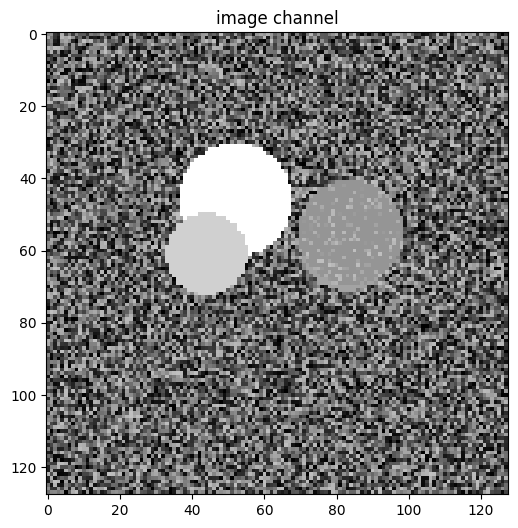

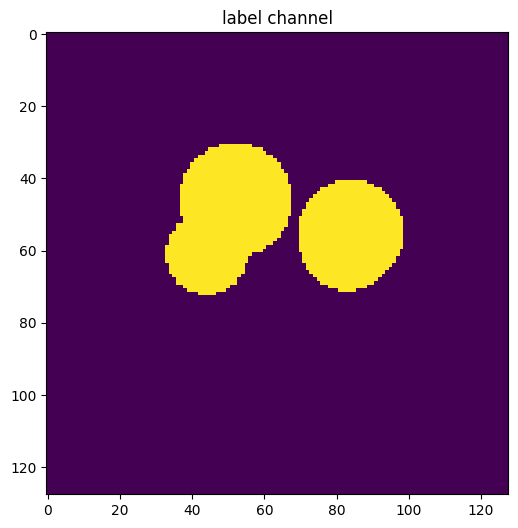

In [48]:
# @title Visualization of one image

patient_index_to_plot = 2

val_data_example = val_ds[patient_index_to_plot]

print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (6, 6))
plt.subplot()
plt.title(f"image channel")
plt.imshow(val_data_example["image"][0,:, :,70].detach().cpu(), cmap="gray")

"""
plt.figure("image", (24, 60))
for i in range(33):
  plt.subplot(9,4,i+1)
  plt.title(f"image channel")
  plt.imshow(val_data_example["image"][0,:, :, i*5].detach().cpu(), cmap="gray")
"""

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (6, 6))
plt.subplot()
plt.title(f"label channel")
plt.imshow(val_data_example["label"][0,:, :,70].detach().cpu())

"""
plt.figure("label", (24, 60))
for i in range(33):
  plt.subplot(9, 4,i+ 1)
  plt.title(f"label channel")
  plt.imshow(val_data_example["label"][0,:, :, 5*i].detach().cpu())
plt.show()
"""

In [56]:
# @title Training setup

max_epochs = 40
val_interval = 1
VAL_AMP = True

device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_train = DiceMetric(include_background=True, reduction="mean")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# use "amp" to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable "cuDNN benchmark"
torch.backends.cudnn.benchmark = True

In [57]:
# @title Training

epoch_loss_values = []
metric_values = []
metric_values_train = []
total_start = time.time()

for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (batch_data["image"].to(device),batch_data["label"].to(device))
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]

        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

----------
epoch 1/40
Loss: 0.4668 
Train dice: 0.7079
Test dice: 0.8510
Time: 16.2572
----------
epoch 2/40
Loss: 0.3897 
Train dice: 0.8917
Test dice: 0.8843
Time: 19.5618
----------
epoch 3/40
Loss: 0.3700 
Train dice: 0.9183
Test dice: 0.9123
Time: 16.4819
----------
epoch 4/40
Loss: 0.3555 
Train dice: 0.9352
Test dice: 0.9300
Time: 15.7159
----------
epoch 5/40
Loss: 0.3457 
Train dice: 0.9428
Test dice: 0.9387
Time: 16.2951
----------
epoch 6/40
Loss: 0.3378 
Train dice: 0.9467
Test dice: 0.9257
Time: 16.1173
----------
epoch 7/40
Loss: 0.3301 
Train dice: 0.9540
Test dice: 0.9427
Time: 17.0442
----------
epoch 8/40
Loss: 0.3226 
Train dice: 0.9583
Test dice: 0.9508
Time: 16.1756
----------
epoch 9/40
Loss: 0.3157 
Train dice: 0.9632
Test dice: 0.9593
Time: 15.8678
----------
epoch 10/40
Loss: 0.3096 
Train dice: 0.9644
Test dice: 0.9513
Time: 15.8422
----------
epoch 11/40
Loss: 0.3033 
Train dice: 0.9672
Test dice: 0.9681
Time: 16.2928
----------
epoch 12/40
Loss: 0.2978 
Trai

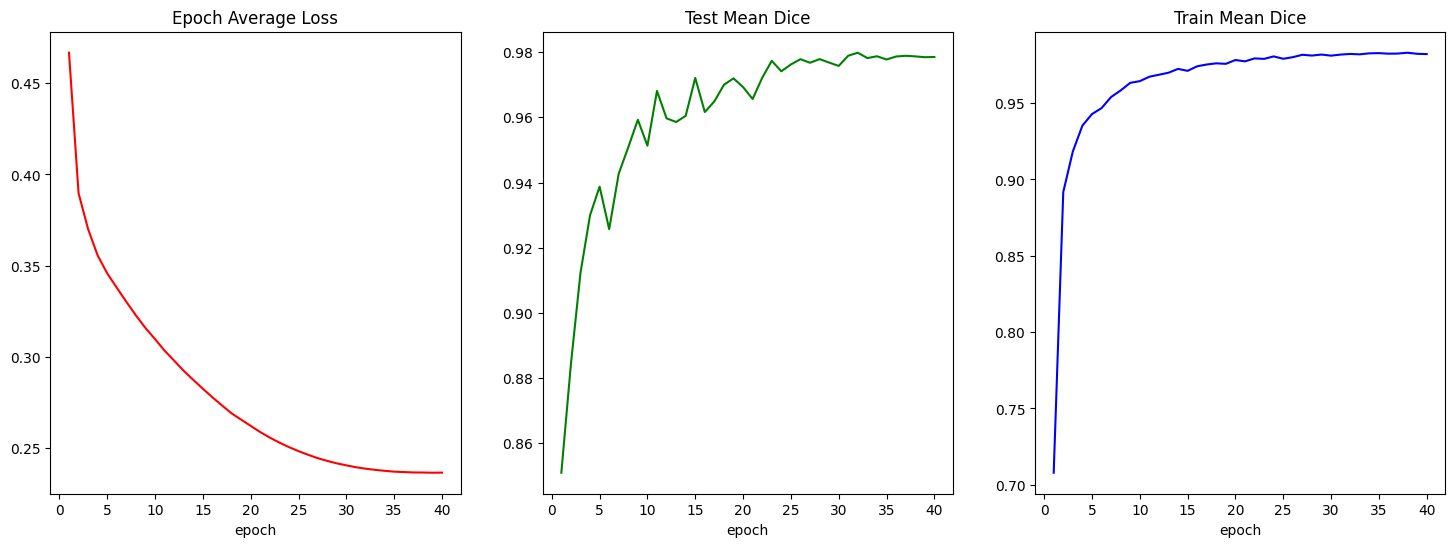

In [58]:
# @title Plot of the model's metrics

plt.figure("train", (18, 6))

# Epoch Average Loss
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")

# Test Mean Dice
plt.subplot(1, 3, 2)
plt.title("Test Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")

# Train Mean Dice
plt.subplot(1, 3, 3)
plt.title("Train Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values_train))]
y = metric_values_train
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.show()

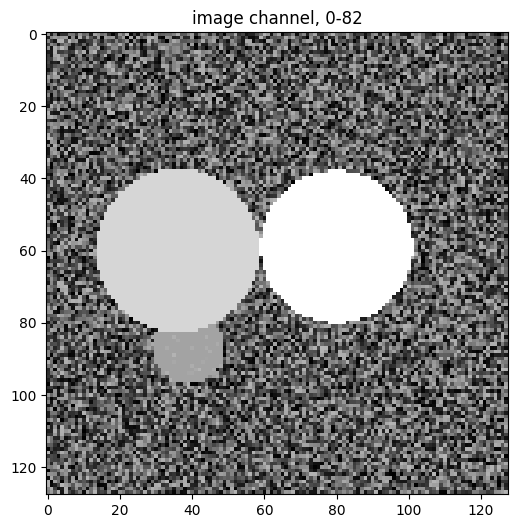

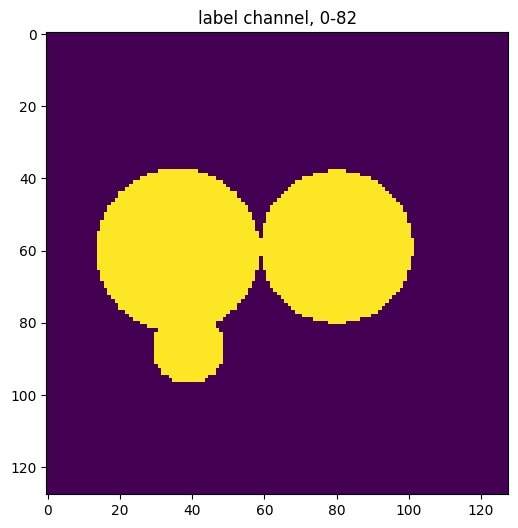

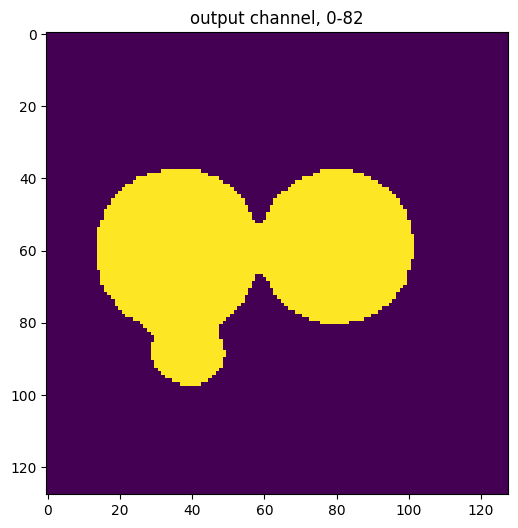

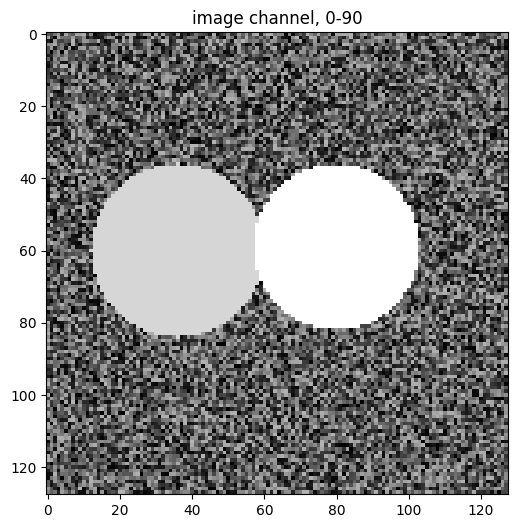

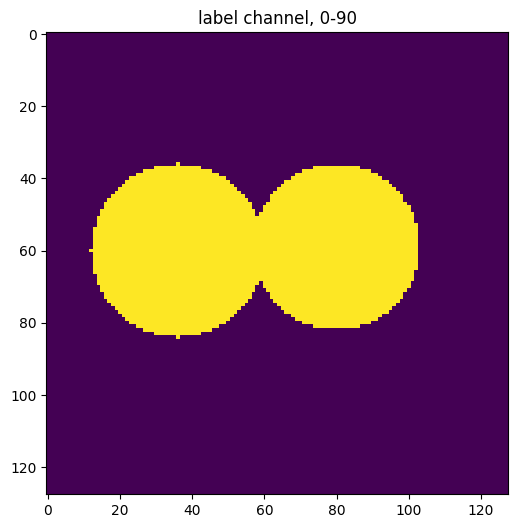

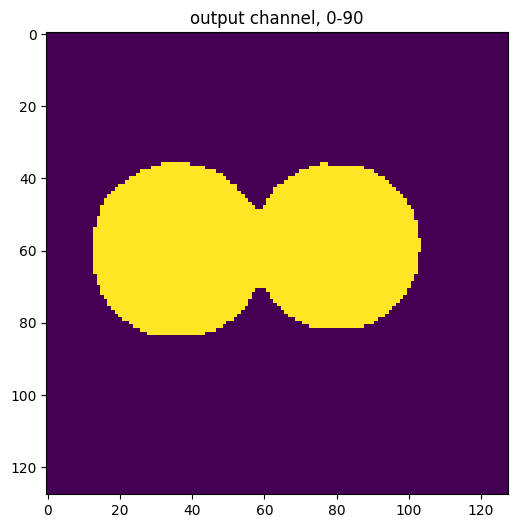

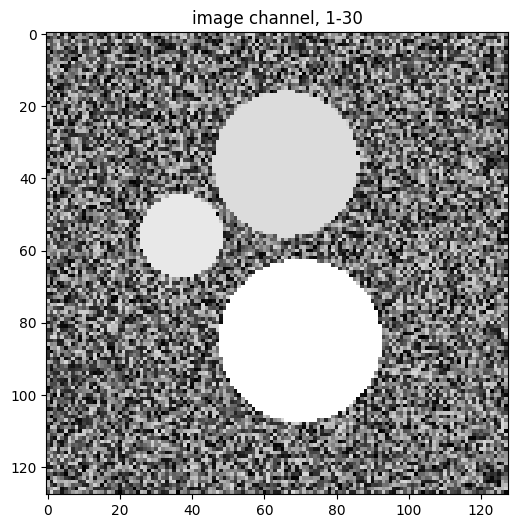

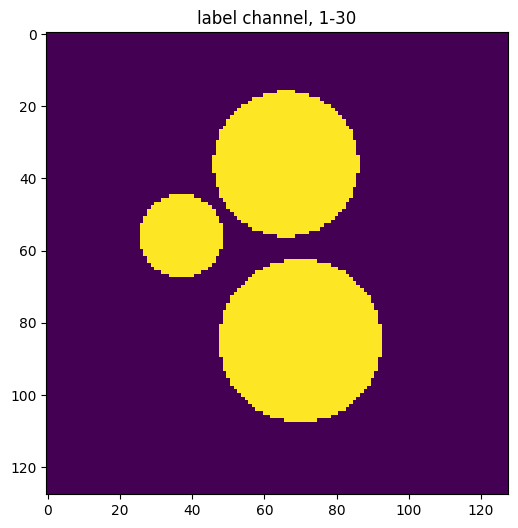

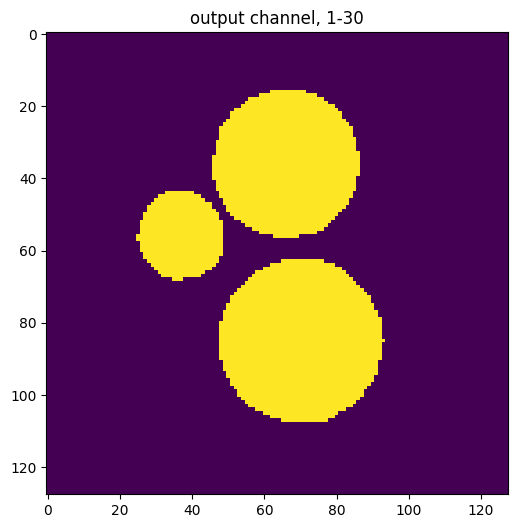

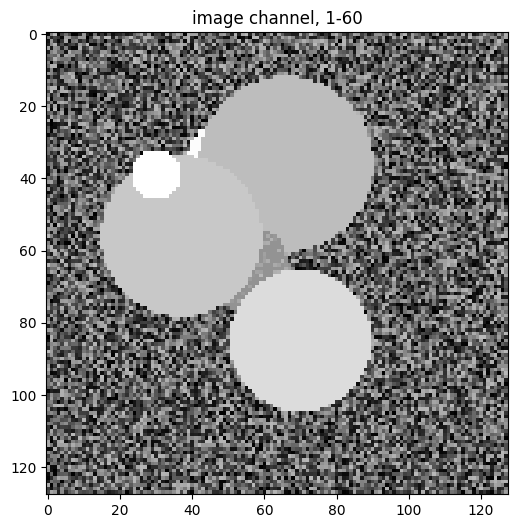

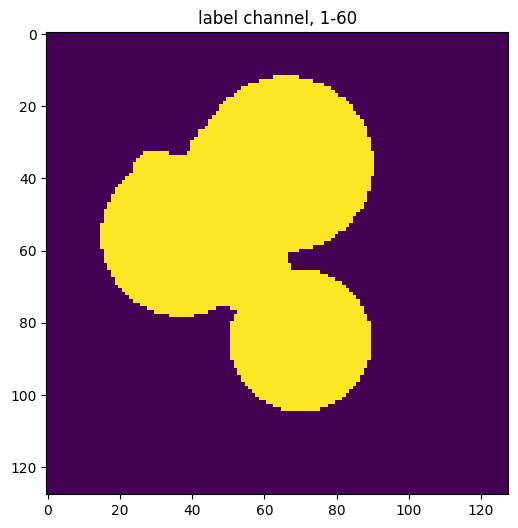

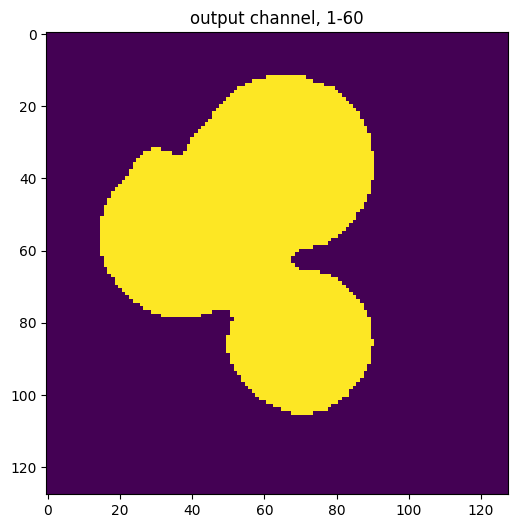

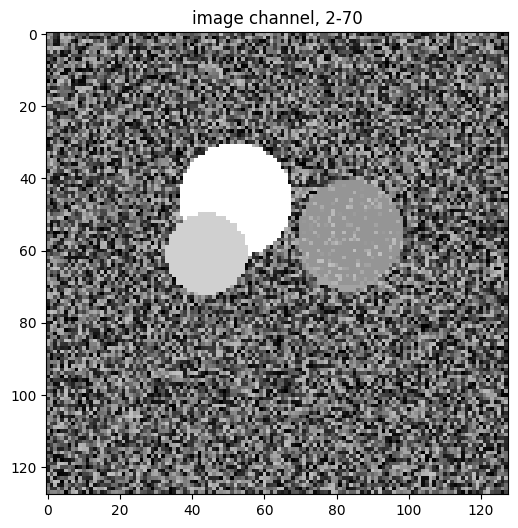

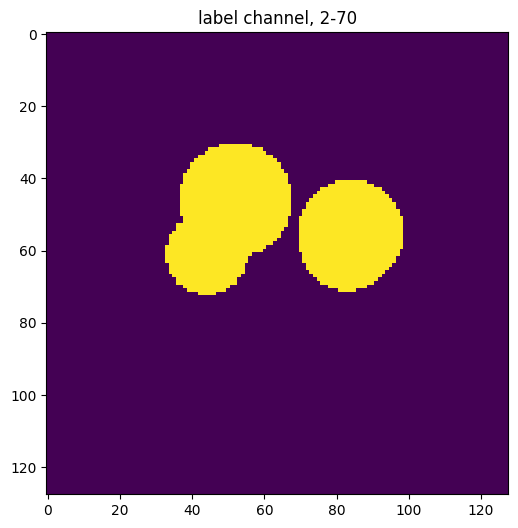

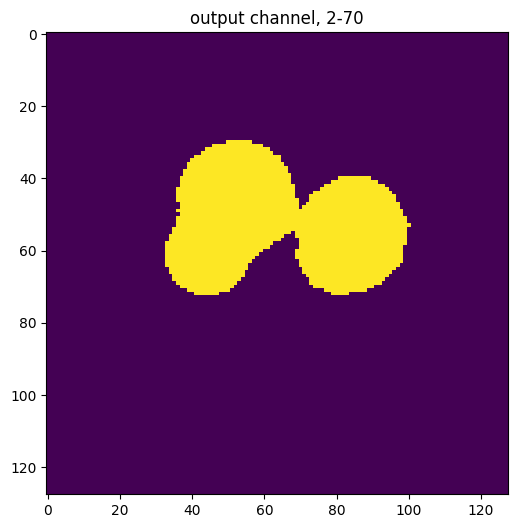

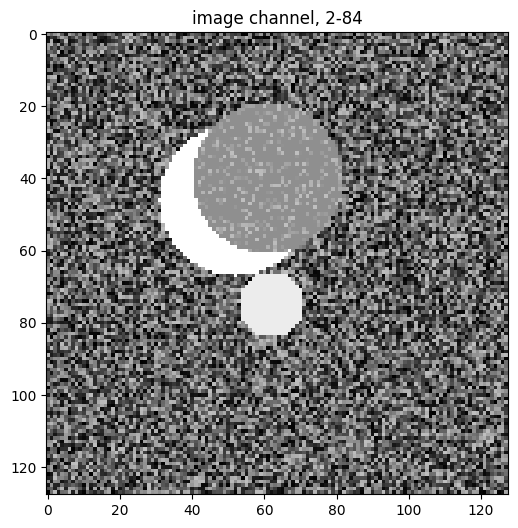

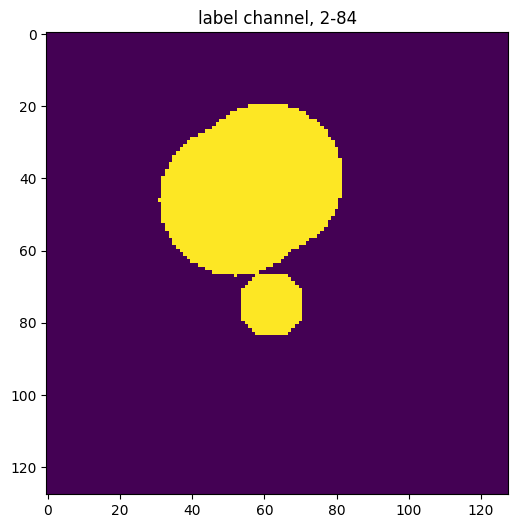

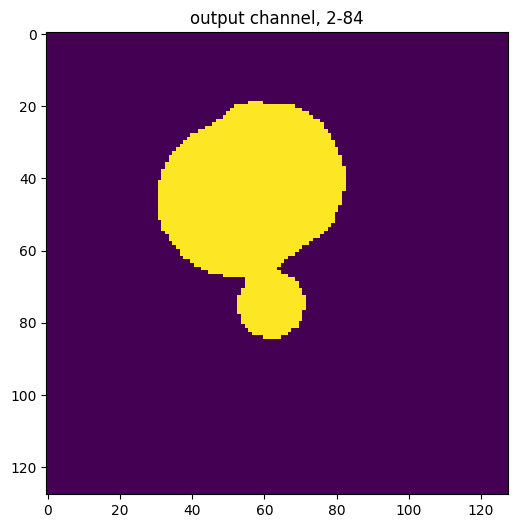

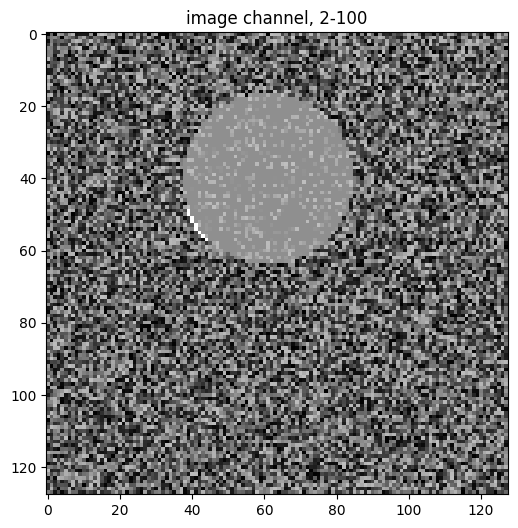

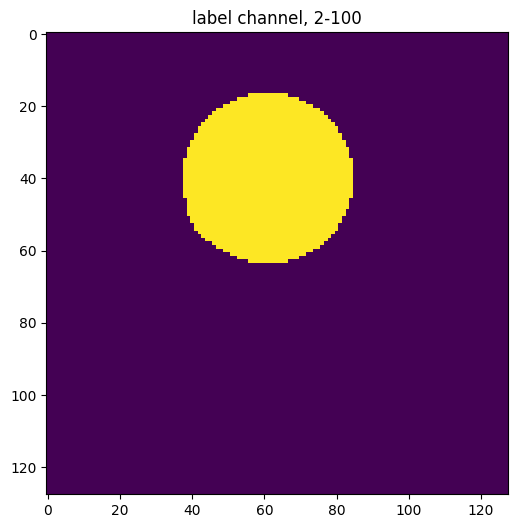

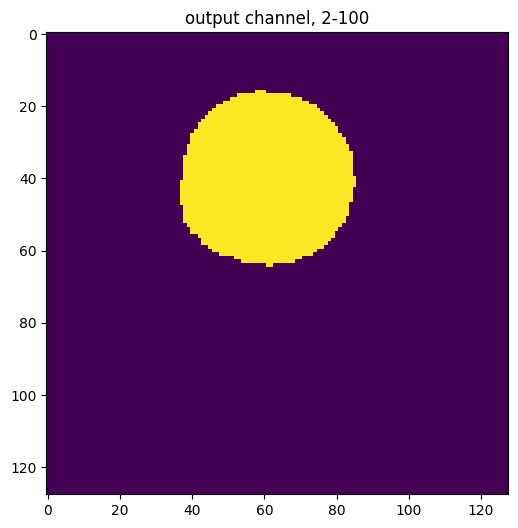

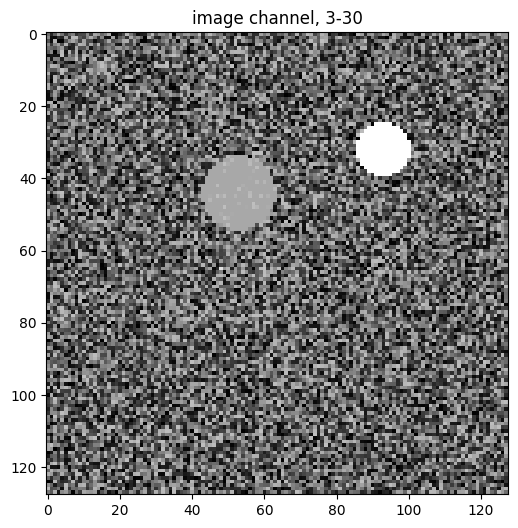

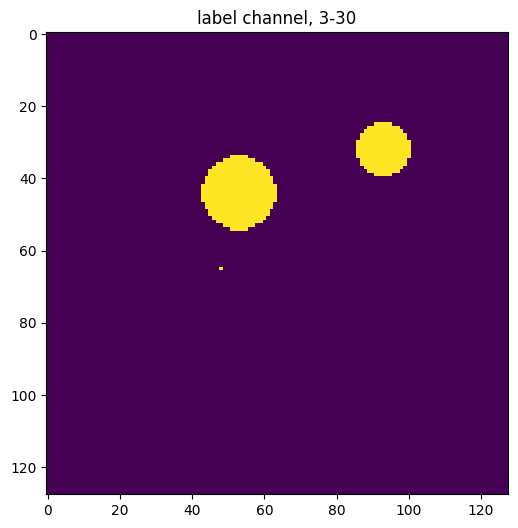

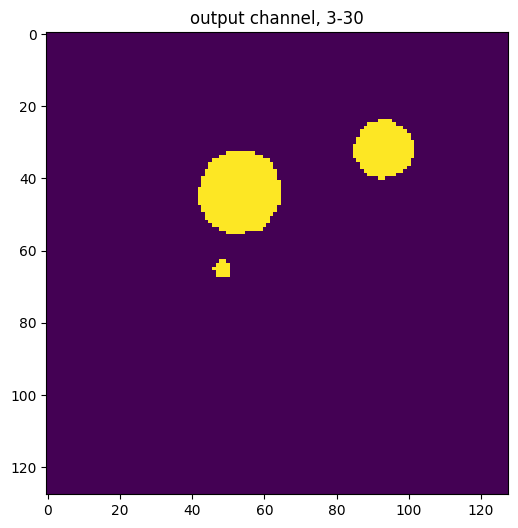

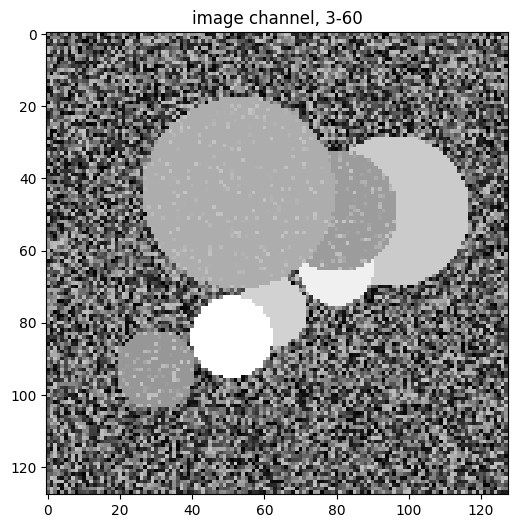

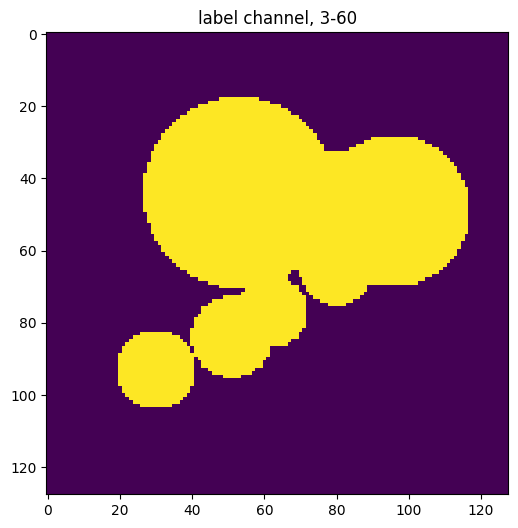

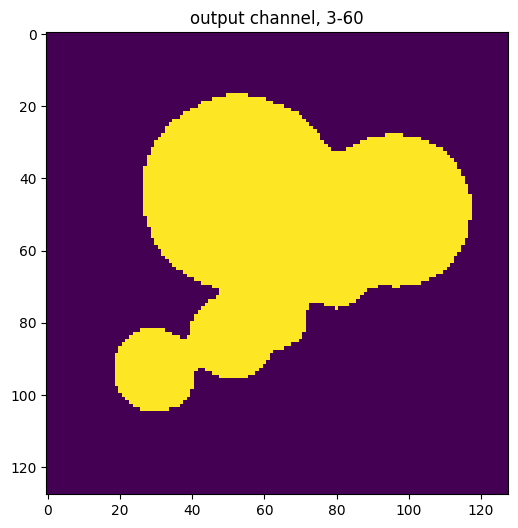

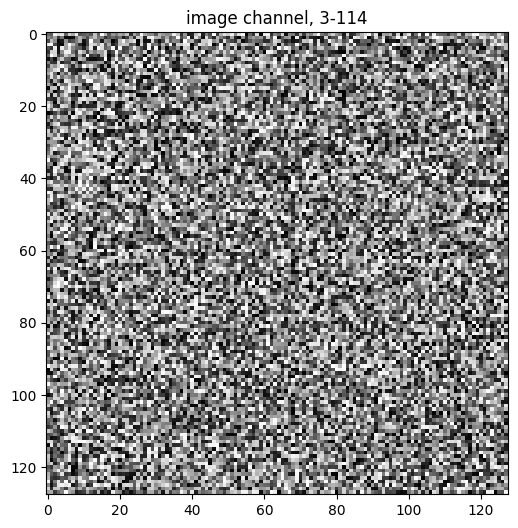

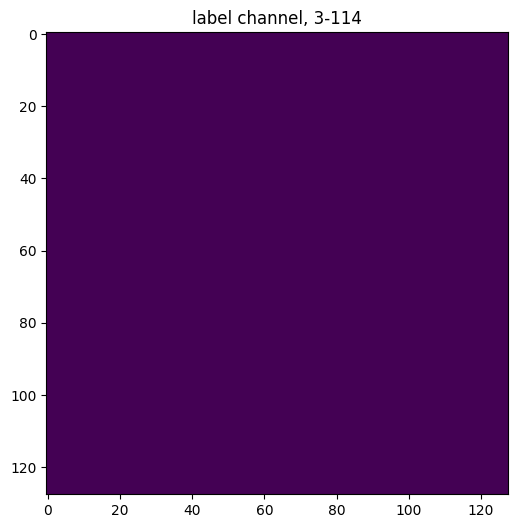

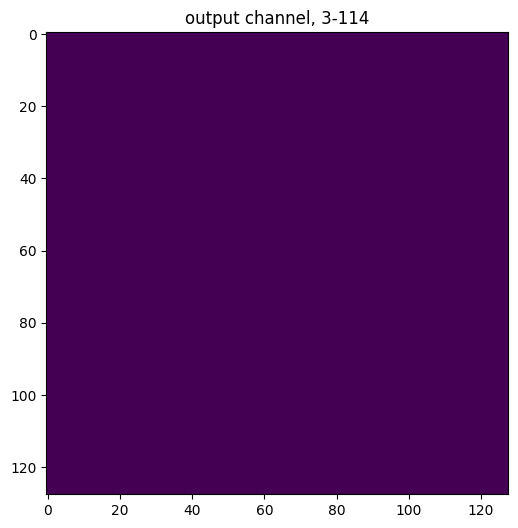

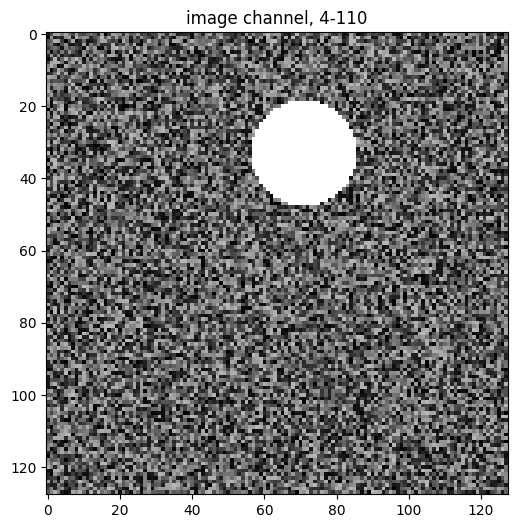

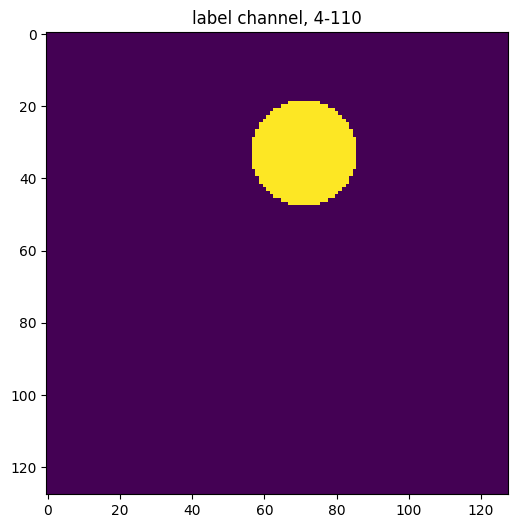

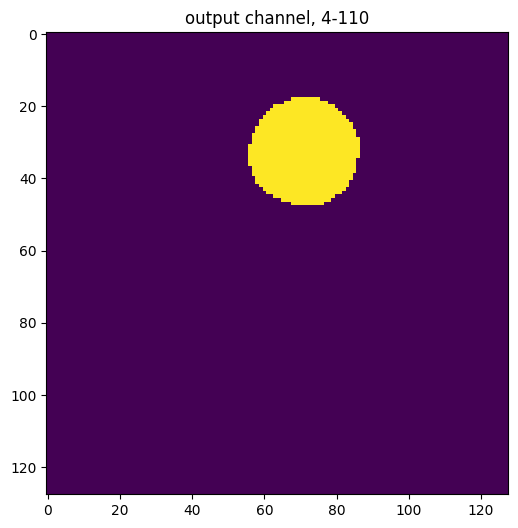

In [60]:
# @title Plot of some testing images
model.eval()

patient_indices = (0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4)
z_axis_values = (82, 90, 30, 60, 70, 84, 100, 30, 60, 114, 110)

with torch.no_grad():
  for k in range(len(patient_indices)):
    # choose "i", index of the testing image to be plotted,
    # and "j", value of the z-axis corresponding to the
    # x-y section to be plotted
    i = patient_indices[k]
    j = z_axis_values[k]

    # select one image to evaluate and visualize the model output
    val_input = val_ds[i]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = model(val_input)
    val_output = post_trans(val_output[0])

    plt.figure("image", (6, 6))
    plt.subplot()
    plt.title(f"image channel, {i}-{j}")
    plt.imshow(val_ds[i]["image"][0, :, :, j].detach().cpu(), cmap="gray")
    plt.show()

    # visualize the channel label corresponding to this image
    plt.figure("label", (6, 6))
    plt.subplot()
    plt.title(f"label channel, {i}-{j}")
    plt.imshow(val_ds[i]["label"][0, :, :, j].detach().cpu())
    plt.show()

    # visualize the channel model output corresponding to this image
    plt.figure("output", (6, 6))
    plt.subplot()
    plt.title(f"output channel, {i}-{j}")
    plt.imshow(val_output[0, :, :, j].detach().cpu())
    plt.show()

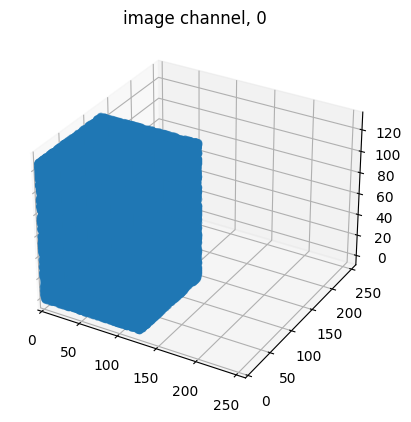

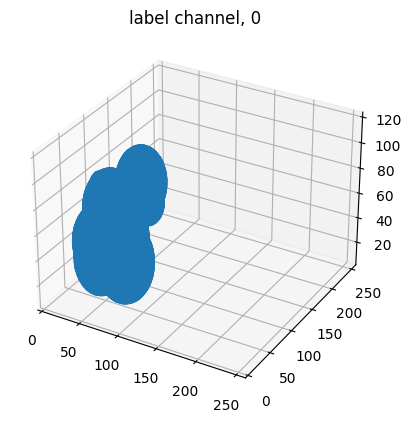

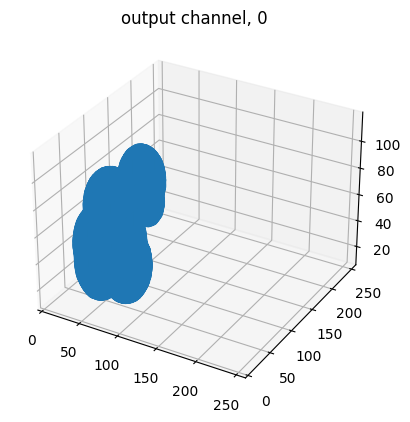

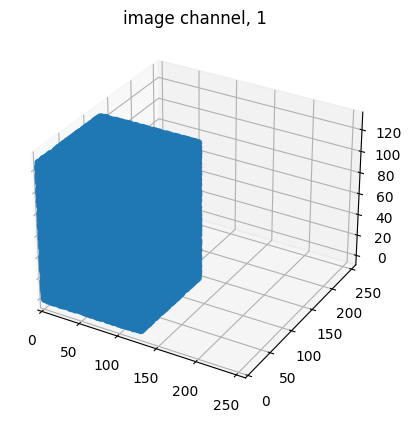

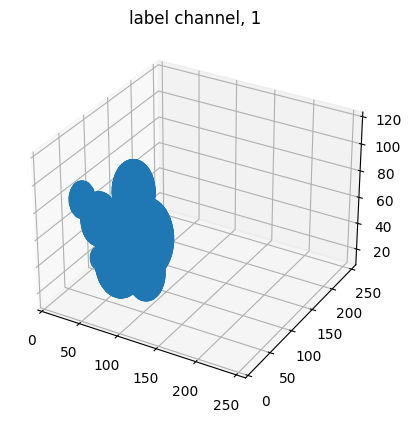

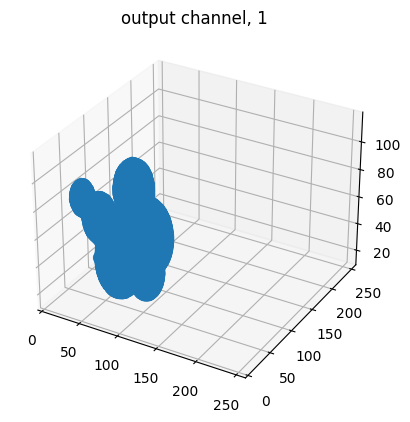

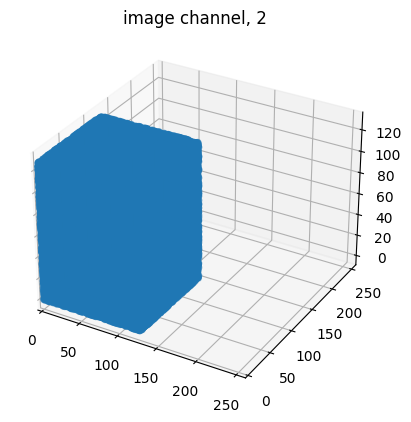

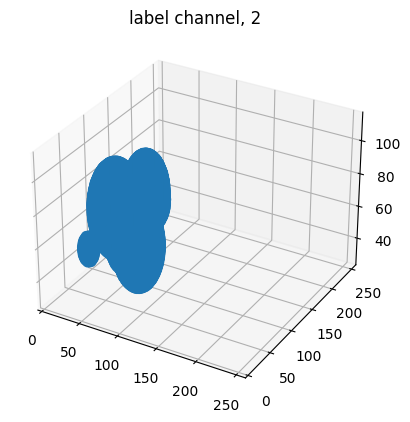

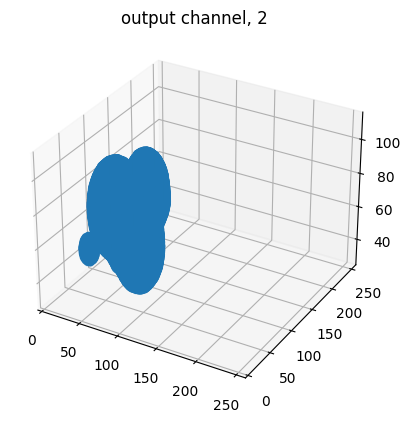

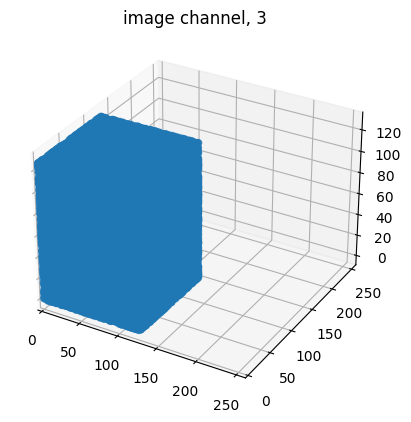

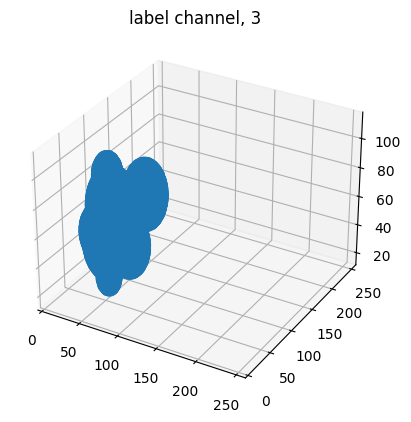

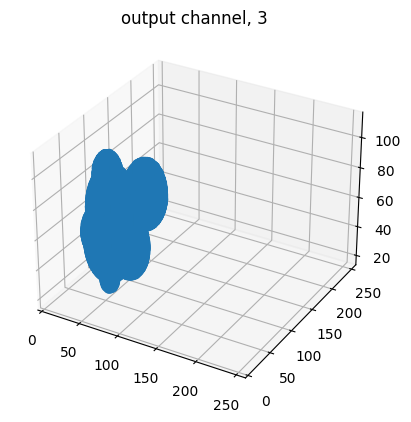

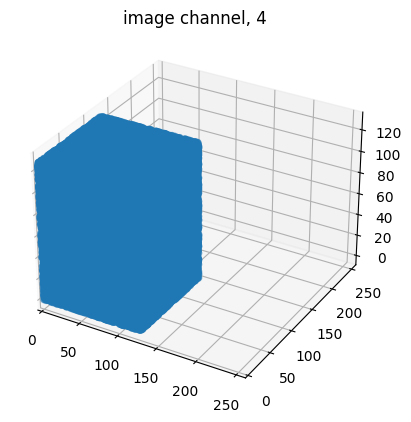

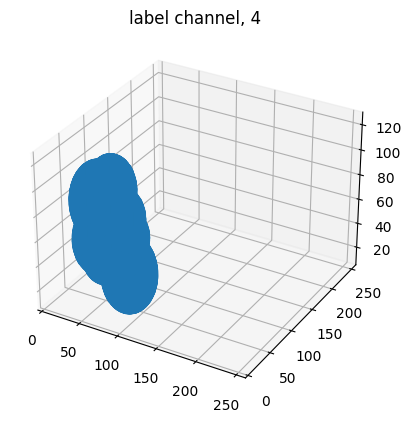

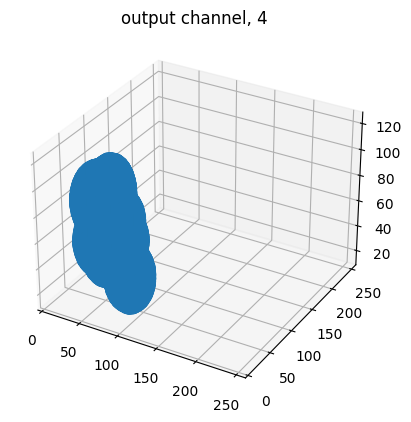

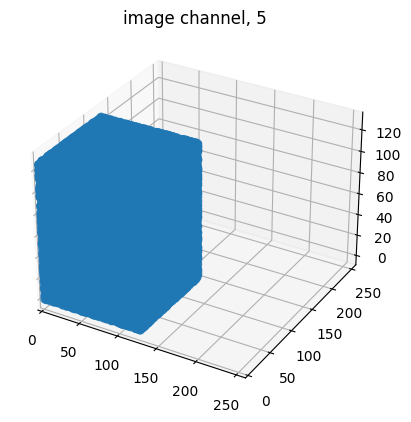

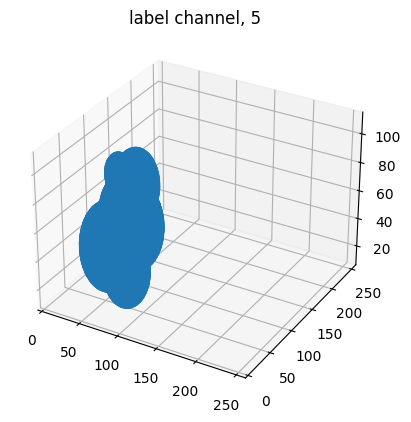

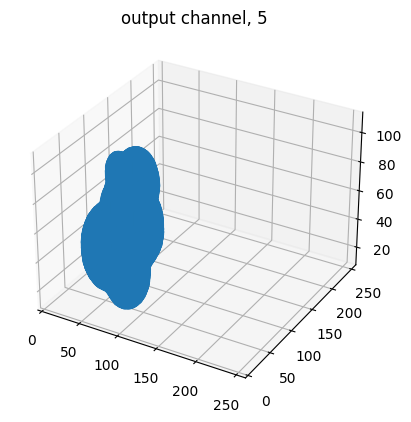

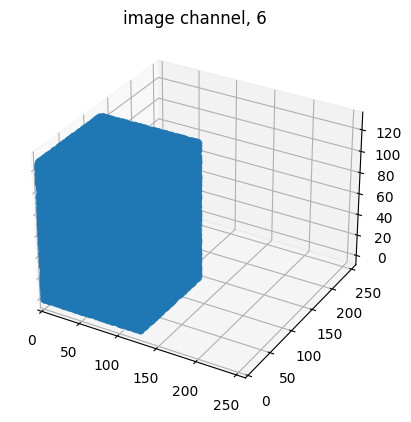

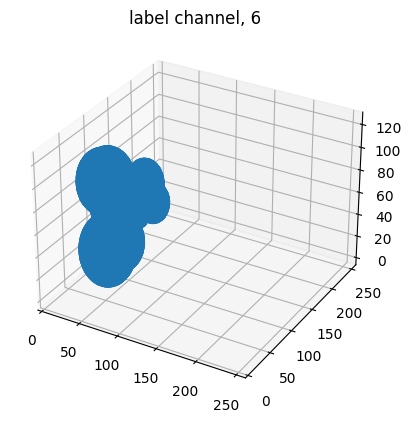

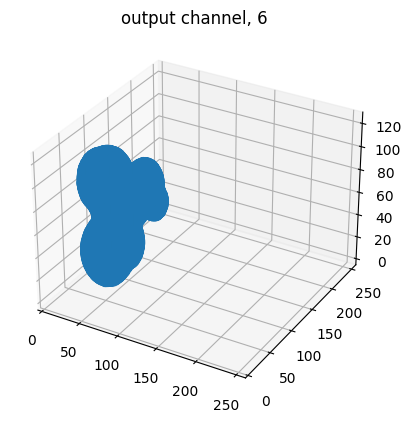

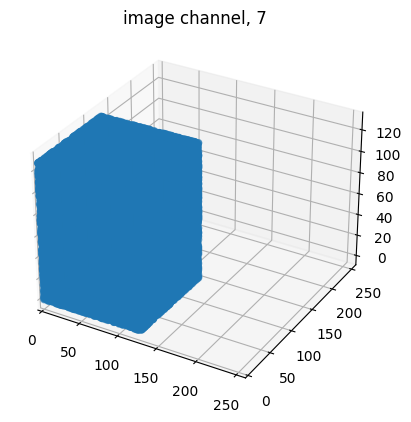

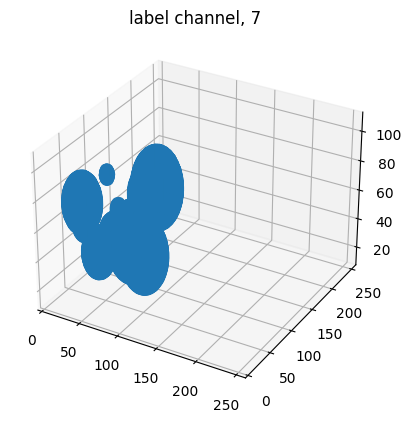

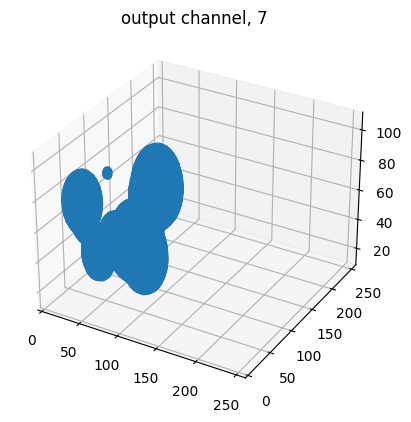

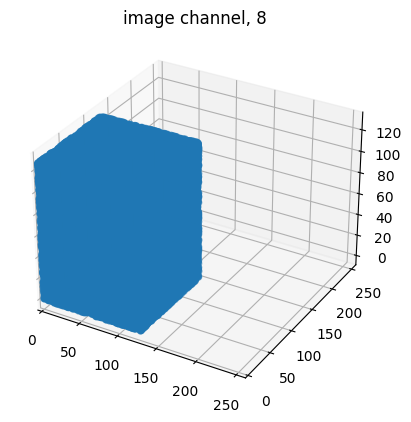

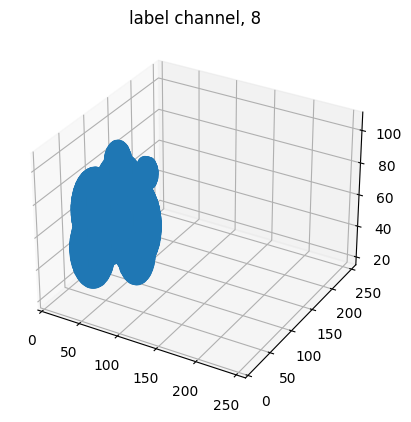

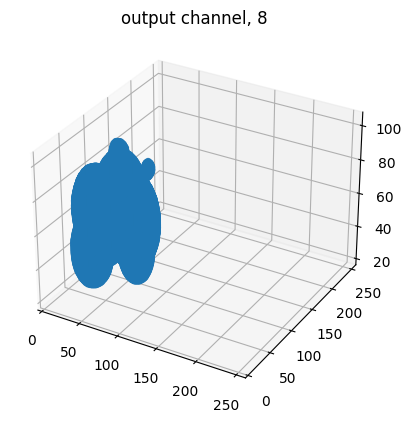

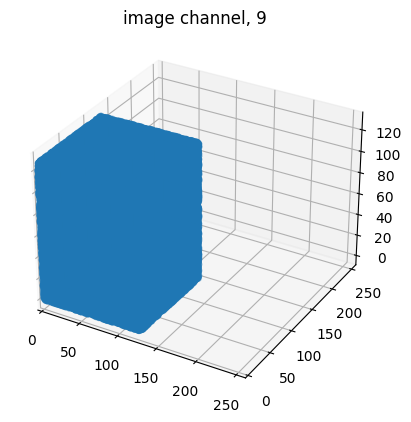

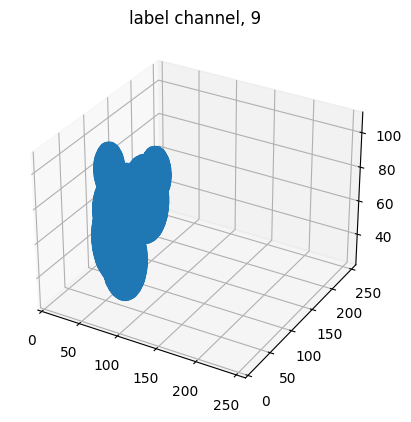

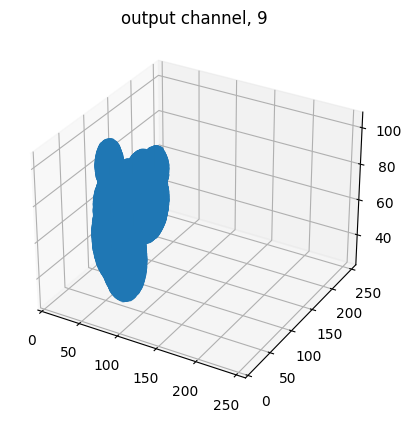

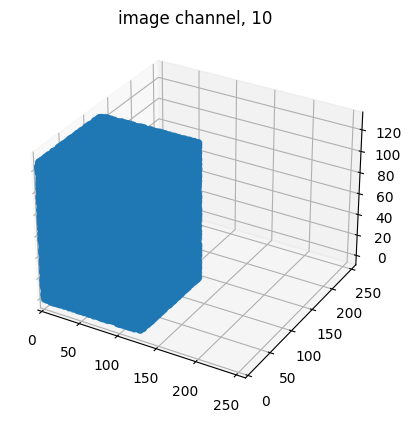

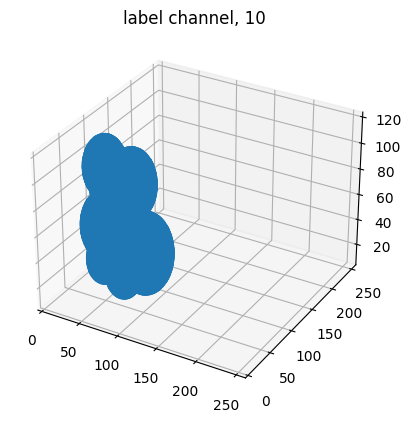

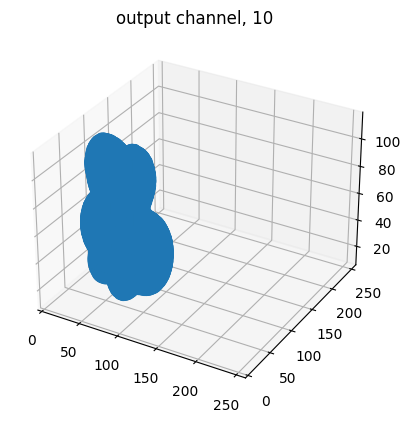

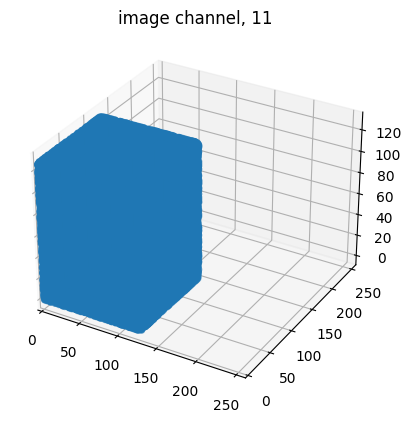

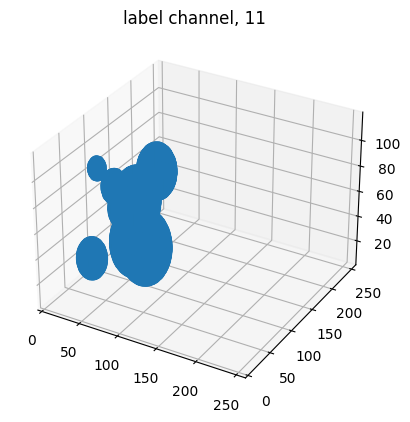

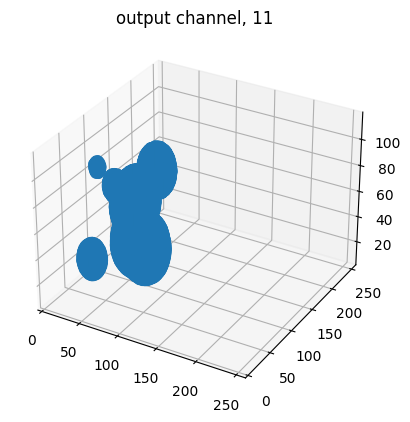

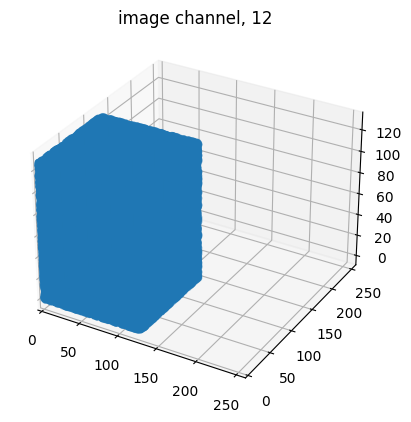

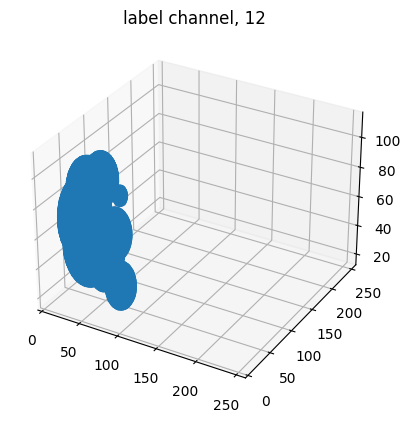

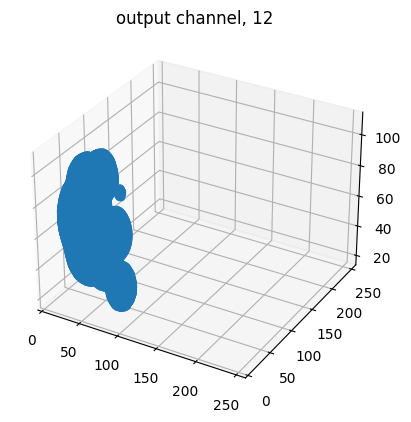

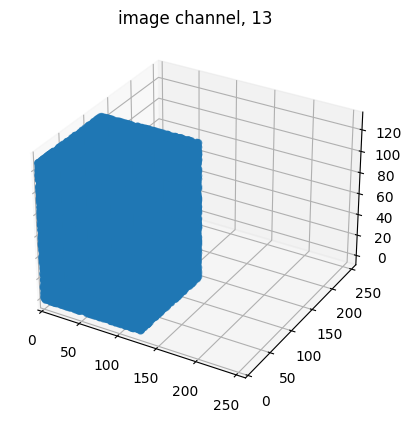

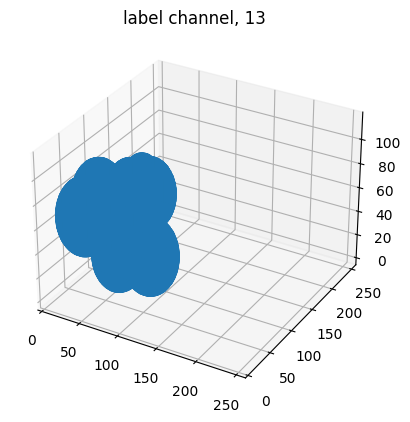

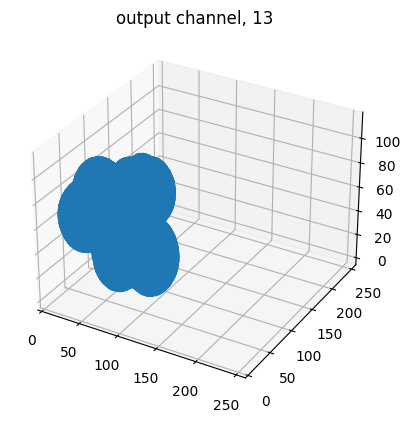

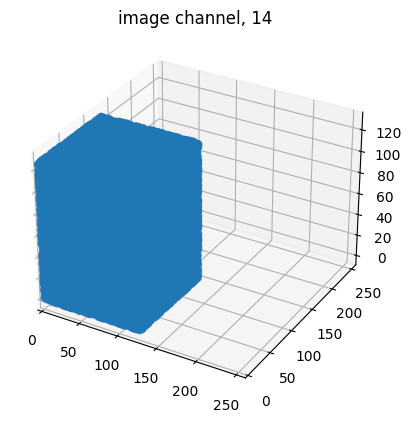

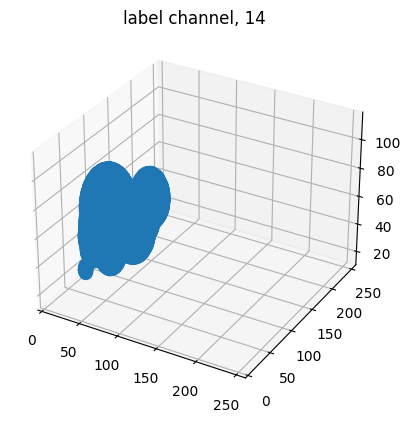

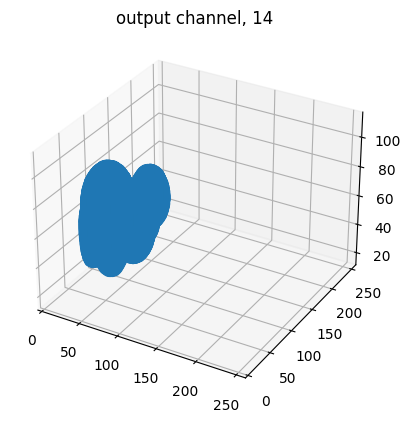

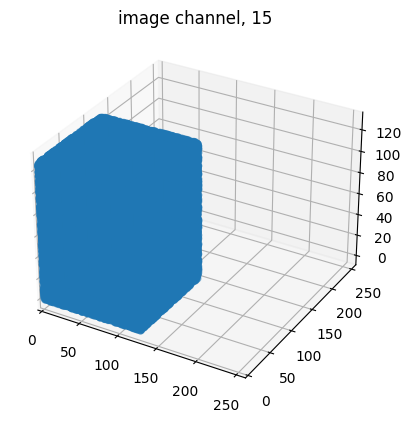

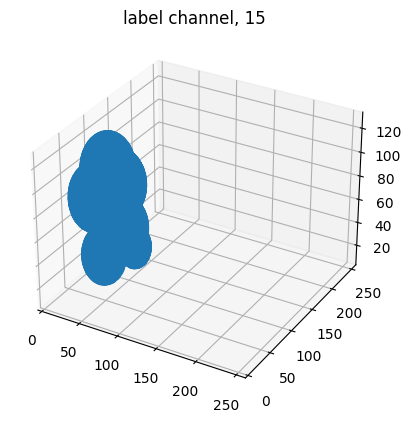

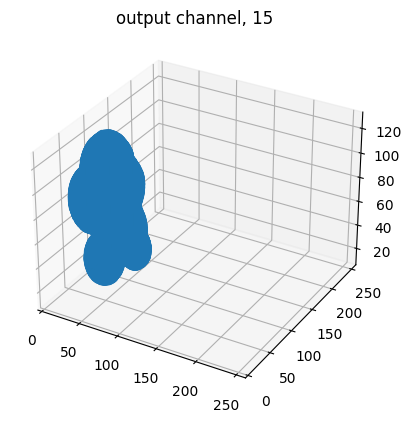

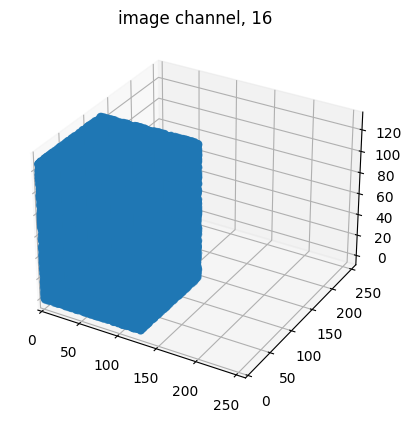

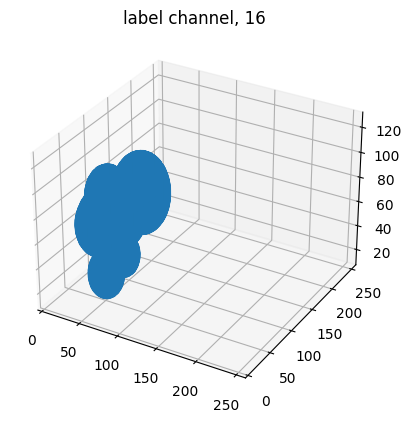

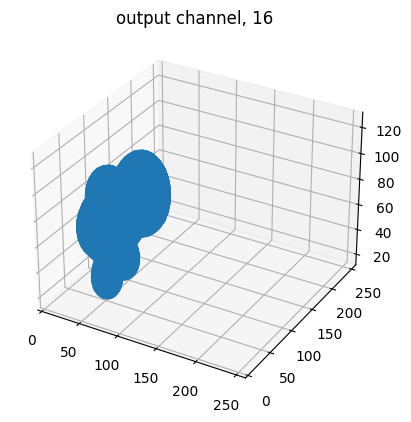

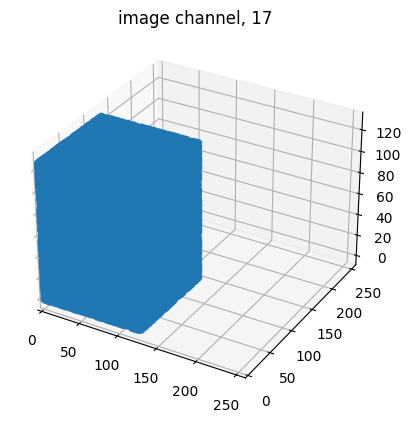

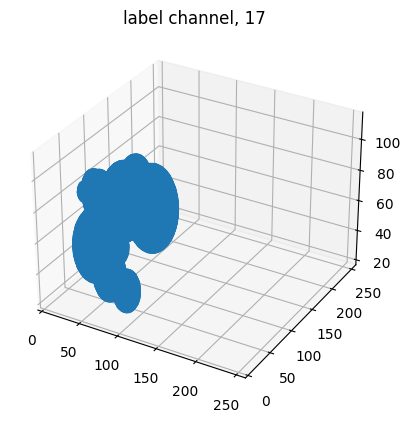

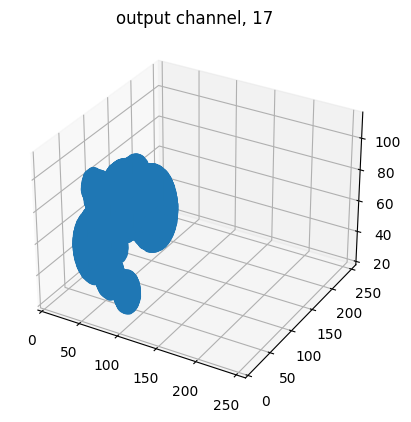

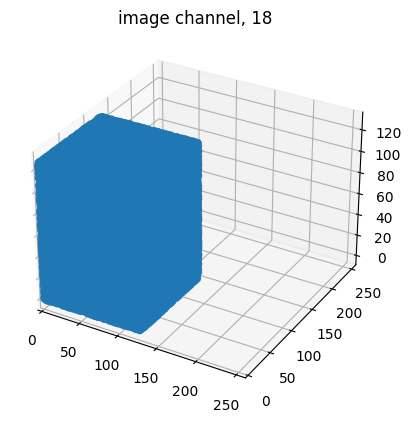

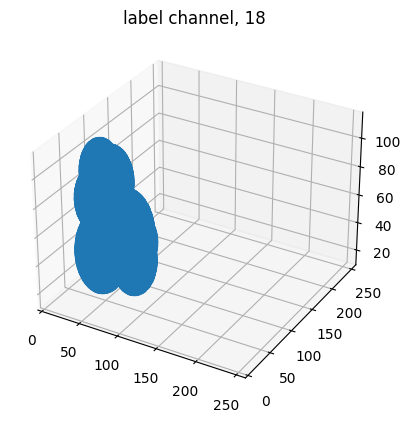

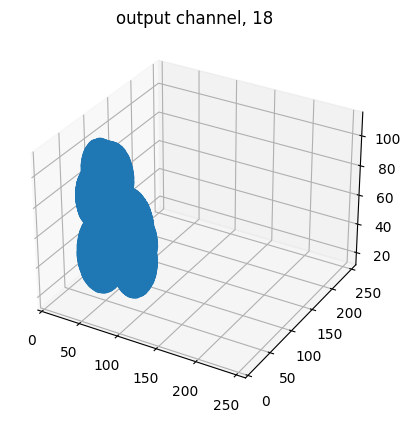

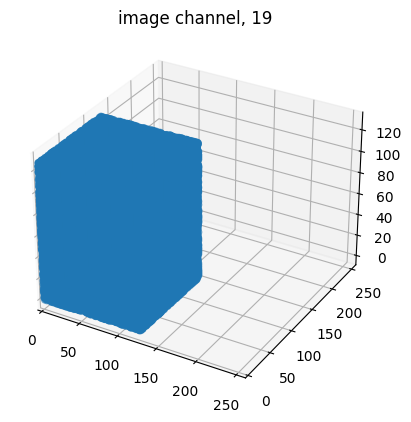

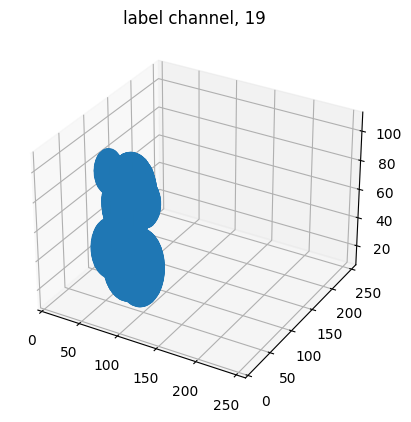

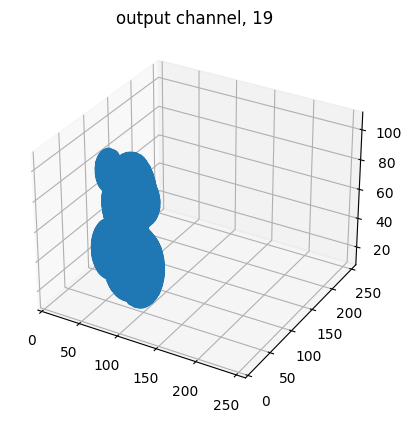

In [ ]:
# @title 3D plot of all the testing images

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

number_val_patients = len(val_ds)

with torch.no_grad():
  for i in range(number_val_patients):
    val_input = val_ds[i]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])

    # 3d plot of the current image
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_ds[i]["image"][0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"image channel, {i}")
    plt.show()

    # 3d plot of the corresponding label
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_ds[i]["label"][0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"label channel, {i}")
    plt.show()

    # 3d plot of the corresponding output
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    z, x, y = val_output[0].astype(np.uint8).nonzero()
    ax.scatter(x, y, z)
    plt.xlim([0,256])
    plt.ylim([0,256])
    plt.title(f"output channel, {i}")
    plt.show()